In [324]:
import sys, platform, os
sys.path.insert(1, '/home/jlonergan/Mat_project/hmvec/hmvec')

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import simps
from params import default_params
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

import csv

Using CAMB 1.3.2 installed at /home/jlonergan/miniconda3/lib/python3.7/site-packages/camb


In [325]:
defaults = {'min_mass':1e6, 'max_mass':1e16, 'num_mass':1000}
constants = {
    'thompson_SI': 6.6524e-29,
    'meter_to_megaparsec': 3.241e-23,
    'G_SI': 6.674e-11,
    'mProton_SI': 1.673e-27,
    'H100_SI': 3.241e-18
}

In [326]:
## Baseline 1
# volume = 100 Gpc^3
# z = 1
# n_g = 2e-4 Mpc^-3
# b_g = 1.6

## Baseline 2
# volume = 100 Gpc^3
# z = 1
# n_g = 1e-2 Mpc^-3
# b_g = 1.6

# Enter baseline values
volume_gpc3 = 100
volume_mpc3 = volume_gpc3 * 1e9
z = [1]
ngalMpc3 = 2e-4
bg_fid = 1.6

In [327]:
kL_min = np.pi/volume_mpc3**(1./3.)
kL_max = 0.1
kS_min = 0.1
kS_max = 10
num_kL_bins = 198
num_mu_bins = 1001
num_kS_bins = 117

In [328]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.3, ombh2=0.02225, omch2=0.1198, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2.2e-9, ns=0.9645, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
pars.set_matter_power(redshifts=[1.0], kmax= kL_max)
pars

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 0.1
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [1.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2650
 max_l_tensor = 600
 max_eta_k = 6625.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02225
 omch2 = 0.1198
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.3
 TCMB = 2.7255
 YHe = 0.24535020213414468
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.9645
   nrun

In [329]:
#calculate results for these parameters
results = camb.get_results(pars)
results

class: <CAMBdata>
 Params: <CAMBparams>
   WantCls = True
   WantTransfer = True
   WantScalars = True
   WantTensors = False
   WantVectors = False
   WantDerivedParameters = True
   Want_cl_2D_array = True
   Want_CMB = True
   Want_CMB_lensing = True
   DoLensing = True
   NonLinear = NonLinear_none
   Transfer: <TransferParams>
     high_precision = True
     accurate_massive_neutrinos = False
     kmax = 0.1
     k_per_logint = 0
     PK_num_redshifts = 1
     PK_redshifts = [1.0]
   want_zstar = False
   want_zdrag = False
   min_l = 2
   max_l = 2650
   max_l_tensor = 600
   max_eta_k = 6625.0
   max_eta_k_tensor = 1200.0
   ombh2 = 0.02225
   omch2 = 0.1198
   omk = 0.0
   omnuh2 = 0.0006451383989381787
   H0 = 67.3
   TCMB = 2.7255
   YHe = 0.24535020213414468
   num_nu_massless = 2.030666666666667
   num_nu_massive = 1
   nu_mass_eigenstates = 1
   share_delta_neff = False
   nu_mass_degeneracies = [1.0153333333333332]
   nu_mass_fractions = [1.0]
   nu_mass_numbers = [1]
   

In [330]:
#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [331]:
# Defining the sigma(z) function
sigz = 0.06

sigma_z_func = lambda z : sigz*(1.0 + z)

In [332]:
H0 = pars.H0
h = H0/100

trans = results.get_matter_transfer_data()
# kL = trans.transfer_data[0,:,0]
kL = np.logspace(np.log10(kL_min),np.log10(kL_max),num_kL_bins)


PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, kmax=h*kL_max, zmax=z[-1])
pL = PK.P(z, kL, grid = True)

growthL = results.get_redshift_evolution(kL, z, ['growth'])[:,:,0]

In [362]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.3, ombh2=0.02225, omch2=0.1198, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2.2e-9, ns=0.9645, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
pars.set_matter_power(redshifts=[1.0], kmax= kS_max)
pars

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 10.0
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [1.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2650
 max_l_tensor = 600
 max_eta_k = 6625.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02225
 omch2 = 0.1198
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.3
 TCMB = 2.7255
 YHe = 0.24535020213414468
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.9645
   nru

In [363]:
#calculate results for these parameters
results = camb.get_results(pars)
results

class: <CAMBdata>
 Params: <CAMBparams>
   WantCls = True
   WantTransfer = True
   WantScalars = True
   WantTensors = False
   WantVectors = False
   WantDerivedParameters = True
   Want_cl_2D_array = True
   Want_CMB = True
   Want_CMB_lensing = True
   DoLensing = True
   NonLinear = NonLinear_none
   Transfer: <TransferParams>
     high_precision = True
     accurate_massive_neutrinos = False
     kmax = 10.0
     k_per_logint = 0
     PK_num_redshifts = 1
     PK_redshifts = [1.0]
   want_zstar = False
   want_zdrag = False
   min_l = 2
   max_l = 2650
   max_l_tensor = 600
   max_eta_k = 6625.0
   max_eta_k_tensor = 1200.0
   ombh2 = 0.02225
   omch2 = 0.1198
   omk = 0.0
   omnuh2 = 0.0006451383989381787
   H0 = 67.3
   TCMB = 2.7255
   YHe = 0.24535020213414468
   num_nu_massless = 2.030666666666667
   num_nu_massive = 1
   nu_mass_eigenstates = 1
   share_delta_neff = False
   nu_mass_degeneracies = [1.0153333333333332]
   nu_mass_fractions = [1.0]
   nu_mass_numbers = [1]
  

In [364]:
#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [365]:
H0 = pars.H0
h = H0/100

trans = results.get_matter_transfer_data()
# kS = trans.transfer_data[0,:,0]
# kS = kS[96:]
kS = np.logspace(np.log10(kS_min),np.log10(kS_max),num_kS_bins)

PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, kmax=h*kS_max, zmax=z[-1])
pS = PK.P(z, kS, grid = True)

growthS = results.get_redshift_evolution(kS, z, ['growth'])[:,:,0]

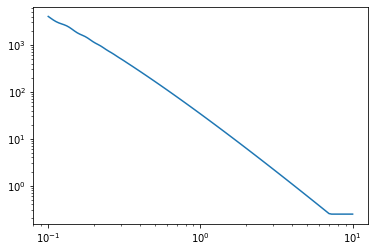

In [366]:
plt.loglog(kS, pS[0])

In [464]:
# Constructing the covariance matrix C
# Starting with the signal covariance matrix S

# entering a fiducial value.
fNL_fid = 0
bg_fid = 1.6
bv_fid = 1.6

# Defining the beta_f parameter
delta_c = 1.42 # critical overdensity at which halos form (double check)
beta_f = 2*delta_c*(bg_fid - 1)


# defining the transfer function
results= camb.get_background(pars)
results.calc_transfers(pars)

def transfer(k):
    transferdata = results.get_matter_transfer_data()
    Tk_camb_matter = transferdata.transfer_z('delta_cdm', z_index=0)
    Tk_camb_matter = Tk_camb_matter/Tk_camb_matter[0]
    h = (pars.H0)/100
    Tk_camb_matter_k = transferdata.q/h
    interpolation = interp1d(Tk_camb_matter_k,Tk_camb_matter,bounds_error=False,fill_value=0.)
    return interpolation(k)

a_min = 0.001
a_max = 1.0
na = 512
atab = np.linspace(a_min, a_max, na)
    
def a2z(a):
    return (1.0/a)-1.0

def D_growth(a):
    ks = np.logspace(np.log10(1e-5),np.log10(1.),num=100) 
    zs = a2z(atab)
    deltakz = results.get_redshift_evolution(ks, zs, ['delta_cdm']) #index: k,z,0
    D_camb = deltakz[0,:,0]/deltakz[0,0,0]
    _da_interp = interp1d(atab, D_camb, kind='linear')
    return _da_interp(a)/_da_interp(1.0)*0.76

D = D_growth(0.5)    
Omega_m = (pars.ombh2 + pars.omch2)/h**2
H0 = pars.H0
h = H0/100
# add exact value for c^2

def alpha(k):
#     return (2 * k**2 * transfer(k) * D * 3e5**2)/(3 * Omega_m * H0**2 * h**2)
    return (2 * k**2 * transfer(k) * D)/(3 * Omega_m * results.h_of_z(0)**2)
alpha_kL = alpha(kL)
alpha_kS = alpha(kS)


# P_vv component:

fS = []
fL = []
a = []
H = []
for i in range(len(z)):
    fS.append(growthS[:,i])
    fL.append(growthL[:,i])
    a.append(1./(1. + z[i]))
    H.append(results.h_of_z(z[i]))
    
fL = fL[0][0] # Setting fL to a constant value, although it shouldn't significantly matter.

fS = fS[0][0]

In [465]:
# Constructing the noise covariance matrix N
# Nvv component:
def _sanitize(inp):
    inp[~np.isfinite(inp)] = 0
    return inp

def get_interpolated_cls(Cls,chistar,kss):
    ls = np.arange(Cls.size)
    Cls[ls<2] = 0
    def _Cls(ell):
        if ell<=ls[-1]:
            return Cls[int(ell)]
        else:
            return np.inf
    # TODO: vectorize
      
    interp = chistar*kss
    for i in range(len(kss)): # Applying the _Cls function to each element of interp
        interp[i] = _Cls(interp[i])
    return interp

def get_kmin(volume_gpc3):
    vol_mpc3 = volume_gpc3 * 1e9
    return np.pi/vol_mpc3**(1./3.)

def chi(Yp,NHe):
    val = (1-Yp*(1-NHe/4.))/(1-Yp/2.)
    return val

def ne0_shaw(ombh2,Yp,NHe=0,me = 1.14,gasfrac = 0.9):
    '''
    Average electron density today
    Eq 3 of 1109.0553
    Units: 1/meter**3
    '''
    omgh2 = gasfrac* ombh2
    mu_e = 1.14 # mu_e*mass_proton = mean mass per electron
    ne0_SI = chi(Yp,NHe)*omgh2 * 3.*(constants['H100_SI']**2.)/constants['mProton_SI']/8./np.pi/constants['G_SI']/mu_e
    return ne0_SI

def ksz_radial_function(z,ombh2, Yp, gasfrac = 0.9,xe=1, tau=0, params=None):
    """
    K(z) = - T_CMB sigma_T n_e0 x_e(z) exp(-tau(z)) (1+z)^2
    Eq 4 of 1810.13423
    """
    if params is None: params = default_params
    T_CMB_muk = params['T_CMB'] # muK
    thompson_SI = constants['thompson_SI']
    meterToMegaparsec = constants['meter_to_megaparsec']
    ne0 = ne0_shaw(ombh2,Yp)
    return T_CMB_muk*thompson_SI*ne0*(1.+z)**2./meterToMegaparsec  * xe  *np.exp(-tau)

In [466]:
chistars = []
Fstar = []
for i in range(len(z)):
    chistars.append(results.comoving_radial_distance(z[i]/1000))
    Fstar.append(ksz_radial_function(z = z[i], ombh2 = pars.ombh2, tau=0.06, Yp = pars.YHe)) 

# volume_gpc3 = (4/3)*np.pi*(results.comoving_radial_distance(z[0])/1000)**3
# kLs = np.geomspace(get_kmin(np.max(volume_gpc3)),kL_max,num_kL_bins) # commenting out since we defined kL earlier
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
Cls = results.get_lensed_scalar_cls(CMB_unit = 'muK', raw_cl = True)
TT = Cls[:,0]

In [467]:
def get_interpolated_cls(Cls,chistar,kss):
    ls = np.arange(Cls.size)
    Cls[ls<2] = 0
    def _Cls(ell):
        if ell<=ls[-1]:
            return Cls[int(ell)]
        else:
            return np.inf
    # TODO: vectorize
      
    interp = chistar*kss
    for i in range(len(kss)): # Applying the _Cls function to each element of interp
        interp[i] = _Cls(interp[i])
    return interp

In [487]:
# Defining mu
mu = np.linspace(-1,1,num_mu_bins)
mu = mu.reshape(len(mu), 1)
    
def Wphoto(z,k, mu):
    return np.exp(-sigma_z_func(z[0])**2. * k**2. * mu**2/2/H[0]**2.) # (mus,kLs)

def d2vs_fun(bv_fid, f, a, H, k): # How to convert matter densities into velocities, fourier space equivalent of continuity equation (momentum conserved)
    return (bv_fid * f * a[0] * H[0])/k

d2vs = d2vs_fun(bv_fid, fS, a, H, kS)

def P_vv_fun(p, d2vs):
    return d2vs**2 * p

P_vv = P_vv_fun(pS, d2vs)
P_vv = np.tile(P_vv, (len(mu), 1))

def P_vg_fun(mu, f, p, d2vs, alpha):
    return p*d2vs*(bg_fid + fNL_fid*(beta_f/alpha))

P_vg = P_vg_fun(mu, fS, pS, d2vs, alpha_kS)

P_gv = P_vg

def P_gg_fun(mu, f, p, alpha):
    return p*(bg_fid + fNL_fid*(beta_f/alpha))**2

P_gg = P_gg_fun(mu, fS, pS, alpha_kS)

In [488]:
def Nvv_core_integral(chi_star,Fstar,mu,kL,kS,Cls,Pge,Pgg_tot,Pgg_photo_tot=None,errs=False,
                      robust_term=False,photo=True):
    """
    Returns velocity recon noise Nvv as a function of mu,kL
    Uses Pgg, Pge function of mu,kL,kS and integrates out kS
    if errs is True: sets Pge=1, so can be reused for Pge error calc
    Cls is an array for C_tot starting at l=0.
    e.g. C_tot = C_CMB + C_fg + (C_noise/beam**2 )
    """
        
    if robust_term:
        if photo: print("WARNING: photo_zs were True for an Nvv(robust_term=True) call. Overriding to False.")
        photo = False

    if errs:
        ret_Pge = Pge.copy()
        Pge = 1.

    amu = np.resize(mu,(kL.size,mu.size)).T
    prefact = amu**(-2.) * 2. * np.pi * chi_star**2. / Fstar**2.

    Clkstot = get_interpolated_cls(Cls,chi_star,kS)
    integrand = _sanitize(kS * ( Pge**2. / (Pgg_tot * Clkstot)))

    if robust_term:
        assert Pgg_photo_tot is not None
        integrand = _sanitize(integrand * (Pgg_photo_tot/Pgg_tot))

    integral = np.trapz(integrand,kS)
    Nvv = prefact.T * integral
#     assert np.all(np.isfinite(Nvv))
    if errs:
        return Nvv,ret_Pge
    else:
        return Nvv

In [489]:
P_ge = bg_fid*pS

In [490]:
# Getting the N_vv component
def N_vv_fun(mu, kL, kS):
    return Nvv_core_integral(chistars[0], Fstar[0], mu, kL, kS, TT, P_ge, P_gg, Pgg_photo_tot = None, errs = False, robust_term = False, photo = True)
N_vv = N_vv_fun(mu, kL, kS)
N_vv = N_vv.T

/home/jlonergan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power
/home/jlonergan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [491]:
# Getting the off-diagonal components
N_vg = np.zeros((len(kL), len(mu)))
N_vg = N_vg.T
N_gv = N_vg

# Getting the N_gg component
def Ngg(k, z, ngalMpc3, W = True):
    if W == True:
        for i in range(len(z)):
            W2 = np.exp(-(k**2 * mu**2 * sigma_z_func(z[i])**2)/H[i]**2)
        return (1./ngalMpc3*W2)
    else: 
        return (1/ngalMpc3)*np.ones(len(k))

N_gg = Ngg(kL, z, ngalMpc3, W = False)

# Getting N_gg to match the dimensions of the other noise components
N_gg = np.tile(N_gg, (len(mu), 1))
N_gg = N_gg

In [492]:
# Resizing everything back to kL size.

alpha_kL = alpha(kL)
d2vs = d2vs_fun(bv_fid, fL, a, H, kL)

P_vv = P_vv_fun(pL, d2vs)
P_vv = np.tile(P_vv, (len(mu), 1)) # adding rows so that the dimensions match the other components. 

P_vg = P_vg_fun(mu, fL, pL, d2vs, alpha_kL)
P_gv = P_vg
P_gg = P_gg_fun(mu, fL, pL, alpha_kL)

TypeError: 'int' object is not callable

In [ ]:
# Constructing the overall signal matrix, noise matrix, and covariance matrix
# Putting elements into matrix:
vel = True

def signal_matrix(v):
    if v == True:
        return [[P_vv, P_vg], [P_vg, P_gg]]
    else:
        return P_gg

def noise_matrix(v):
    if v == True:
        return [[N_vv, N_vg], [N_vg, N_gg]]
    else:
        return N_gg


S = np.array(signal_matrix(vel))
N = np.array(noise_matrix(vel))
C = S + N

In [493]:
C.shape

(2, 2, 1001, 198)

In [494]:
C[:,:,0,0]

array([[  854.68966574,  5019.10805059],
       [ 5019.10805059, 34840.78937435]])

In [495]:
def C_inverse(C, v):
    
#         inv_det = 1/(P_vv*P_gg - P_vg*P_gv)
#         return inv_det*[[P_gg, -P_vg], [-P_gv, P_vv]]

#         return np.linalg.inv(C)
  
    C_inv = np.zeros((2,2,len(mu), len(kL)))
    if v == True:
        for i in range(len(mu)):
            for j in range(len(kL)):
                C_inv[:,:,i,j] = np.linalg.inv(C[:,:,i,j])
        return C_inv
    else:
        return 1/P_gg

In [496]:
C_inv = C_inverse(C,v = vel)

In [497]:
C.shape

(2, 2, 1001, 198)

In [498]:
# Writing the elements for the derivative matrix
def Pvv_fNL(k):
    return np.zeros((len(mu), len(k)))
P_vv_fNL = Pvv_fNL(kL)

def Pvv_bg(k):
    return np.zeros((len(mu), len(k)))
P_vv_bg = Pvv_bg(kL)

def Pvv_bv(k, p, f):
    pre_tile = 2 * bv_fid * ((fL*a[0]*H[0])/k)**2 * p
    return np.tile(pre_tile, (len(mu), 1))
P_vv_bv = Pvv_bv(kL, pL, fL)

def Pvg_fNL(k, p, f, alpha):
    pre_tile = bv_fid * ((f*a[0]*H[0])/k) * (beta_f/alpha) * p
    return np.tile(pre_tile, (len(mu), 1))
P_vg_fNL = Pvg_fNL(kL, pL, fL, alpha_kL)

def Pvg_bg(k, p, f):
    pre_tile = bv_fid * ((f*a[0]*H[0])/k) * p
    return np.tile(pre_tile, (len(mu), 1))
P_vg_bg = Pvg_bg(kL, pL, fL)

def Pvg_bv(k, p, f, alpha, mu):
    return ((f*a[0]*H[0])/k) * (bg_fid + fNL_fid * (beta_f/alpha) + f * mu**2) * p
P_vg_bv = Pvg_bv(kL, pL, fL, alpha_kL, mu)

def Pgv_fNL(k, p, f, alpha):
    return (bv_fid * ((f*a[0]*H[0])/k) * beta_f * p)/(k*alpha)
P_gv_fNL = Pvg_fNL(kL, pL, fL, alpha_kL)

def Pgv_bg(k, p, f):
    return bv_fid * ((f*a[0]*H[0])/k) * p
P_gv_bg = Pvg_bg(kL, pL, kL)

def Pgv_bv(k, p, f, alpha, mu):
    return ((f*a[0]*H[0])/k) * (bg_fid + fNL_fid * (beta_f/alpha) + f * mu**2) * p
P_gv_bv = Pvg_bv(kL, pL, fL, alpha_kL, mu)

def Pgg_fNL(mu, f, p, alpha):
    return 2*(bg_fid + fNL_fid * (beta_f/alpha) + f*mu**2) * (beta_f/alpha) * p
P_gg_fNL = Pgg_fNL(mu, fL, pL, alpha_kL)

def Pgg_bg(mu, f, p, alpha):
    return 2 * (bg_fid + fNL_fid * (beta_f/alpha) + f*mu**2) * p
P_gg_bg = Pgg_bg(mu, fL, pL, alpha_kL)

def Pgg_bv(k):
    return np.zeros((len(mu), len(k)))
P_gg_bv = Pgg_bv(kL)

In [499]:
# Entering each derivative into a matrix
def my_C_fNL(v):
    if v == True:
        return [[P_vv_fNL, P_vg_fNL], [P_gv_fNL, P_gg_fNL]]
    else:
        return P_gg_fNL
C_fNL = np.array(my_C_fNL(v = vel))

def my_C_bg(v):
    if v == True:
        return [[P_vv_bg, P_vg_bg], [P_gv_bg, P_gg_bg]]
    else:
        return P_gg_bg
C_bg = np.array(my_C_bg(v = vel))

def my_C_bv(v):
    if v == True:
        return [[P_vv_bv, P_vg_bv], [P_gv_bv, P_gg_bv]]
    else:
        return P_gg_bv
C_bv = np.array(my_C_bv(v = vel))

In [500]:
# Constructing the fisher Matrix

def fisher_integrand(k, C_a, C_b, v = False):
    if v == True:
        integrand = np.zeros((len(mu), len(kL)))
        
        for i in range(len(mu)):
            for j in range(len(kL)):
                M1 = np.dot(C_b[:,:,i,j], C_inv[:,:,i,j])
                M2 = np.dot(C_inv[:,:,i,j], M1)
                M3 = np.dot(C_a[:,:,i,j], M2)
                integrand[i][j] = np.trace(M3)
        return ((1e9*volume_gpc3 * k**2)/(8 * np.pi**2)) * integrand
    else:
        return ((1e9*volume_gpc3 * k**2)/(8 * np.pi**2)) * (C_a * C_inv * C_b * C_inv)

In [501]:
if vel == True:
    F = np.zeros((3,3))
    d = {
        0 : C_fNL,
        1 : C_bg,
        2 : C_bv,
    }
else:
    F = np.zeros((2,2))
    d = {
    0 : C_fNL,
    1 : C_bg,
}
    
for alpha in d:
    for beta in d:
        integrand = fisher_integrand(kL, d[alpha], d[beta], v = vel)
        fisher_element = np.trapz(np.trapz(integrand.T, mu.T), kL)
        F[alpha][beta] = fisher_element
F

array([[ 5.80399458e-02,  7.01440575e+01, -2.69121529e+00],
       [ 7.01440575e+01,  6.43631934e+05, -4.29567626e+03],
       [-2.69121529e+00, -4.29567626e+03,  4.40730180e+03]])

In [502]:
cov_params = np.linalg.inv(F)
errs = np.sqrt(np.diag(cov_params))
errs

array([4.50528780e+00, 1.33797332e-03, 1.52844331e-02])

In [361]:
cov_params

array([[ 2.75967883e+01, -2.49913310e-03,  1.20162917e-02],
       [-2.49913310e-03,  1.79017466e-06,  4.36066886e-07],
       [ 1.20162917e-02,  4.36066886e-07,  2.33621979e-04]])

In [129]:
test = np.array([[1, 2], [3, 7]])
np.trace(test)

8

In [69]:
test1 = np.array([[[[0, 1] , [2, 3]], [[4, 5], [6, 7] ]], [[[8,9] , [10,11] ], [[12,13] , [14,15] ]]])
test2 = test1 + 1

In [70]:
test1

array([[[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15]]]])

In [71]:
test2

array([[[[ 1,  2],
         [ 3,  4]],

        [[ 5,  6],
         [ 7,  8]]],


       [[[ 9, 10],
         [11, 12]],

        [[13, 14],
         [15, 16]]]])

In [72]:
test1*test2

array([[[[  0,   2],
         [  6,  12]],

        [[ 20,  30],
         [ 42,  56]]],


       [[[ 72,  90],
         [110, 132]],

        [[156, 182],
         [210, 240]]]])

In [90]:
np.zeros((len(mu), len(kL))).shape

(1001, 198)